In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''') 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
#print(preDouble)

# <font color="#E56717">IOBS & IBA Project Update</font>

# <font color="#E56717">November 2016</font>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
#print(preDouble)

# <font color="#E56717">First order of business is to identify all the patients in the SEER-Medicare data who have received PBT</font>

<span style="font-size:1.5em;">The relevant HCPCS codes are:</span>

* <span style="font-size:1.5em;">77520 - Proton trmt simple w/o comp</span>
* <span style="font-size:1.5em;">77522 - Proton trmt simple w/comp</span>
* <span style="font-size:1.5em;">77523 - Proton trmt intermediate</span>
* <span style="font-size:1.5em;">77525 - Proton treatment complex</span>

# <font color="#E56717">Also find all the patients who received IMRT treatment (delivery; not just planning)</font>

* <span style="font-size:1.5em;">77418</span>
* <span style="font-size:1.5em;">0073T</span>

# <font color="#E56717">Also identify all patients who have received chemotherapy. Use the following codes:</font>

* <span style="font-size:1.5em;">HCPCS codes: 
['J9000', 'J9010', 'J9015', 'J9017', 'J9019', 'J9020', 'J9025', 'J9027', 'J9031', 'J9032', 'J9033', 'J9035', 'J9039', 'J9040', 'J9041', 'J9042', 'J9043', 'J9045', 'J9047', 'J9050', 'J9055', 'J9060', 'J9065', 'J9070', 'J9098', 'J9100', 'J9120', 'J9130', 'J9150', 'J9151', 'J9155', 'J9160', 'J9171', 'J9178', 'J9179', 'J9181', 'J9185', 'J9190', 'J9200', 'J9201', 'J9206', 'J9207', 'J9208', 'J9211', 'J9228', 'J9230', 'J9245', 'J9250', 'J9260', 'J9261', 'J9262', 'J9263', 'J9264', 'J9266', 'J9267', 'J9268', 'J9270', 'J9271', 'J9280', 'J9293', 'J9299', 'J9300', 'J9301', 'J9302', 'J9303', 'J9305', 'J9306', 'J9307', 'J9308', 'J9310', 'J9315', 'J9320', 'J9328', 'J9330', 'J9340', 'J9351', 'J9354', 'J9355', 'J9357', 'J9360', 'J9370', 'J9371', 'J9390', 'J9400', 'J9600', 'J9999', 'G8927', 'G8928', 'G8929', 'G8975', 'J8499', 'J8999', 'Q0081', 'Q0083', 'Q0084', 'Q0085', 'Q0161', 'Q0162', 'Q0163', 'Q0164', 'Q0166', 'Q0167', 'Q0169', 'Q0173', 'Q0174', 'Q0175', 'Q0177', 'Q0180', 'Q0181', 'S2340', 'S2341', 'S9329', 'S9330', 'S9331', '0519F', '36640', '36823', '4180F', '46505', '52287', '61517', '64611', '64612', '64615', '64616', '64617', '64642', '64643', '64644', '64645', '64646', '64647', '64650', '64653', '65435', '67345', '81535', '81536', '86155', '95873', '95874', '96401', '96402', '96405', '96406', '96409', '96411', '96413', '96415', '96416', '96417', '96420', '96422', '96423', '96425', '96440', '96446', '96450', '96542', '96549', '96910', '96912', '96913']</span>
* <span style="font-size:1.5em;">icd-9-dx code: V5811	Encounter for antineoplastic chemo enc</span>
* <span style="font-size:1.5em;">icd-9-sg code: 9925 Inject ca chemother NEC</span>

<span style="font-size:1.5em;">And then use set logic to capture only those PBT patients who did not also receive IMRT. We will then intersect the IMRT and PBT patients with the chemo patients and just add **received_chemo** as a feature; to be used in the matching as well.  Will include stage (did not before)

In [4]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

In [5]:
mask = (df['srvm1'] != 9999)
#dfall = df[mask]

In [6]:
df['modx1'].isnull().sum()

4852

In [7]:
df.shape

(728516, 496)

In [8]:
newmask = (df['dajcct1'].isnull() | df['dajccn1'].isnull() | df['dajccm1'].isnull() | df['dajccstg1'].isnull() | \
          df['modx1'].isnull())

dfall = df[mask & ~newmask]
#dfall = df[mask]

In [9]:
geomask = (dfall['elevation_1'] != dfall['FIPScombo_1']) 

dfall = dfall[geomask].copy()

In [10]:
dfall['elevation_1'].replace('99999',np.nan,inplace=True)
dfall['elevation_2'].replace('99999',np.nan,inplace=True)
dfall['elevation_3'].replace('99999',np.nan,inplace=True)

dfall['lat_1'].replace('99999',np.nan,inplace=True)
dfall['lat_2'].replace('99999',np.nan,inplace=True)
dfall['lat_3'].replace('99999',np.nan,inplace=True)

dfall['lng_1'].replace('99999',np.nan,inplace=True)
dfall['lng_2'].replace('99999',np.nan,inplace=True)
dfall['lng_3'].replace('99999',np.nan,inplace=True)

dfall['elevation_1'] = dfall['elevation_1'].astype('float')
dfall['elevation_2'] = dfall['elevation_2'].astype('float')
dfall['elevation_3'] = dfall['elevation_3'].astype('float')

dfall['lat_1'] = dfall['lat_1'].astype('float')
dfall['lat_2'] = dfall['lat_2'].astype('float')
dfall['lat_3'] = dfall['lat_3'].astype('float')

dfall['lng_1'] = dfall['lng_1'].astype('float')
dfall['lng_2'] = dfall['lng_2'].astype('float')
dfall['lng_3'] = dfall['lng_3'].astype('float')

In [11]:
import pickle
fileObject = open('patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_outsaf = list(set.union(*b))

In [12]:
import pickle
fileObject = open('patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_nch = list(set.union(*b))

In [13]:
bigtreatmentindices = list(set(treatmentindices_nch+treatmentindices_outsaf))

dfall.set_index('patient_id', inplace=True,drop=False)

allindices = dfall.index

In [14]:
bigtreatmentset = set(bigtreatmentindices)
allset = set(allindices)


alltreatmentindices = list(allset.intersection(bigtreatmentset))

treatmentindices = alltreatmentindices
len(treatmentindices)

1591

In [15]:
import pickle
fileObject = open('imrt_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_outsaf = list(set.union(*b))

In [16]:
import pickle
fileObject = open('imrt_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_nch = list(set.union(*b))

In [17]:
bigcontrolindices = list(set(controlindices_nch+controlindices_outsaf))

In [18]:
bigcontrolset = set(bigcontrolindices)
allset = set(allindices)


allcontrolindices = list(allset.intersection(bigcontrolset))

controlindices = allcontrolindices
len(controlindices)

62013

In [19]:
puretreatmentindices = list(set(treatmentindices).difference(set(controlindices)))
len(puretreatmentindices)

1512

In [20]:
purecontrolindices = list(set(controlindices).difference(set(treatmentindices)))
len(purecontrolindices)

61934

# <font color="#E56717">Now import the chemo patients</font>

In [21]:
import pickle
fileObject = open('chemo_ids_from_medpar.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
chemo_medpar = list(set.union(*b))

In [22]:
import pickle
fileObject = open('chemo_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
chemo_outsaf = list(set.union(*b))

In [23]:
import pickle
fileObject = open('chemo_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
chemo_nch = list(set.union(*b))

In [24]:
bigchemoindices = list(set(chemo_medpar + chemo_outsaf + chemo_nch))
len(bigchemoindices)

175972

# <font color="#E56717">Now use the pedsf files to perform patient matching, using the patient_id's found above</font>

<span style="font-size:1.5em;">List of pedsf files (contains SEER diagnosis year dates 2006-2011)</span>

* <span style="font-size:1.5em;">pedsf.nasopharunx.cancer.txt</span>
* <span style="font-size:1.5em;">pedsf.salivary.cancer.txt</span>
* <span style="font-size:1.5em;">pedsf.oropharynx.cancer.txt</span>
* <span style="font-size:1.5em;">pedsf.esophagus.cancer.txt</span>
* <span style="font-size:1.5em;">pedsf.brain.cancer.txt</span>
* <span style="font-size:1.5em;">pedsf.eyeandorbit.cancer.txt</span>
* <span style="font-size:1.5em;">pedsf.softtissue.cancer.txt</span>
* <span style="font-size:1.5em;">pedsf.prostate.cancer.file01.txt</span>
* <span style="font-size:1.5em;">pedsf.prostate.cancer.file02.txt</span>
* <span style="font-size:1.5em;">pedsf.prostate.cancer.file03.txt</span>
* <span style="font-size:1.5em;">pedsf.lung.cancer.file01.txt</span>
* <span style="font-size:1.5em;">pedsf.lung.cancer.file02.txt</span>
* <span style="font-size:1.5em;">pedsf.breast.cancer.file01.txt</span>
* <span style="font-size:1.5em;">pedsf.breast.cancer.file02.txt</span>

# <font color="#E56717">The pedsf files contain one single row for each patient, and contain information for up to ten different primary tumors</font>

<span style="font-size:1.5em;">So the prostate cancer files contain all patients with a cancer diagnosis where the primaryh site is the prostate for ANY of the potentially 10 different tprimary tumors associated with that patient and where that prostate site tumor has a diagnosis date anywhere between 2006 and 2011.</span>

In [25]:
import pedsfhelp

df2 = pedsfhelp.make_clean_dataframe('pedsf.salivarygland.cancer.txt')
#print(df2.shape)

<span style="font-size:1.5em;">For example, in the file pedsf.salivarygland.cancer.txt, the cancer site for the first tumor listed for each patient has the following distribution:</span>

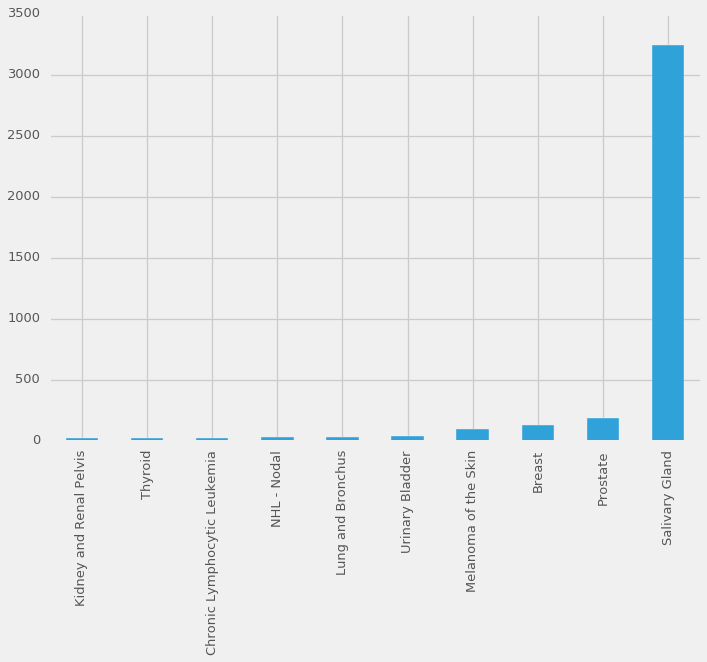

In [26]:
import mpld3
mpld3.disable_notebook()
df2.siterwho1.value_counts()[:10][::-1].plot(kind='bar')

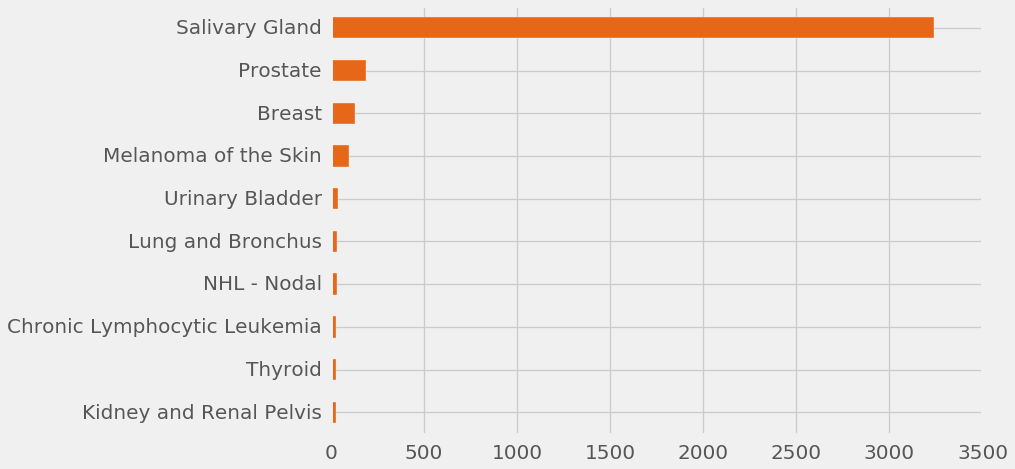

In [27]:
df2.siterwho1.value_counts()[:10][::-1].plot(kind='barh',
                                            color='#E56717');
plt.tick_params(labelsize=20)

# <font color="#E56717">Only keep those patients whose first tumor is at the site indicated in the corresponding file</font>

<span style="font-size:1.5em;">This way we avoid the complications other than the cancer under consideration that may be contributing factors to the outcomes we are analyzing. Also restrict the analysis to those patients who received some form of radiation treatment for this first diagnosis as indicated by the SEER data. Also, only keep those patients that SEER says received radiation (the seer radiation flag also indicates that the radiation was the first course of treament)</span>

* <span style="font-size:1.5em;">1144 PBT patients that did not receive IMRT</span>
* <span style="font-size:1.5em;">47653 IMRT patients that did not receive any PBT</span>

In [28]:
from IPython.display import display
from ipywidgets import *
# create a simple dataset of people
data = {'Name': ["John", "Anna", "Peter", "Linda"],
        'Location' : ["New York", "Paris", "Berlin", "London"],
        'Age' : [24, 13, 53, 33]
       }

data_pandas = pd.DataFrame(data)
# IPython.display allows "pretty printing" of dataframes
# in the Jupyter notebook
display(data_pandas)
print(pd.__version__)

,Age,Location,Name
0,24,New York,John
1,13,Paris,Anna
2,53,Berlin,Peter
3,33,London,Linda


0.18.0


In [29]:
dfall.patient_id.isin(puretreatmentindices).sum()

1512

In [30]:
dfall.patient_id.isin(purecontrolindices).sum()

61934

In [31]:
dfall.shape

(699260, 496)

In [32]:
non_rad1 = dfall.rad1.str.contains('None',case=False,na=False)
refused_rad1 = dfall.rad1.str.contains('refused',case=False,na=False)
unknown_rad1 = dfall.rad1.str.contains('unknown',case=False,na=False)

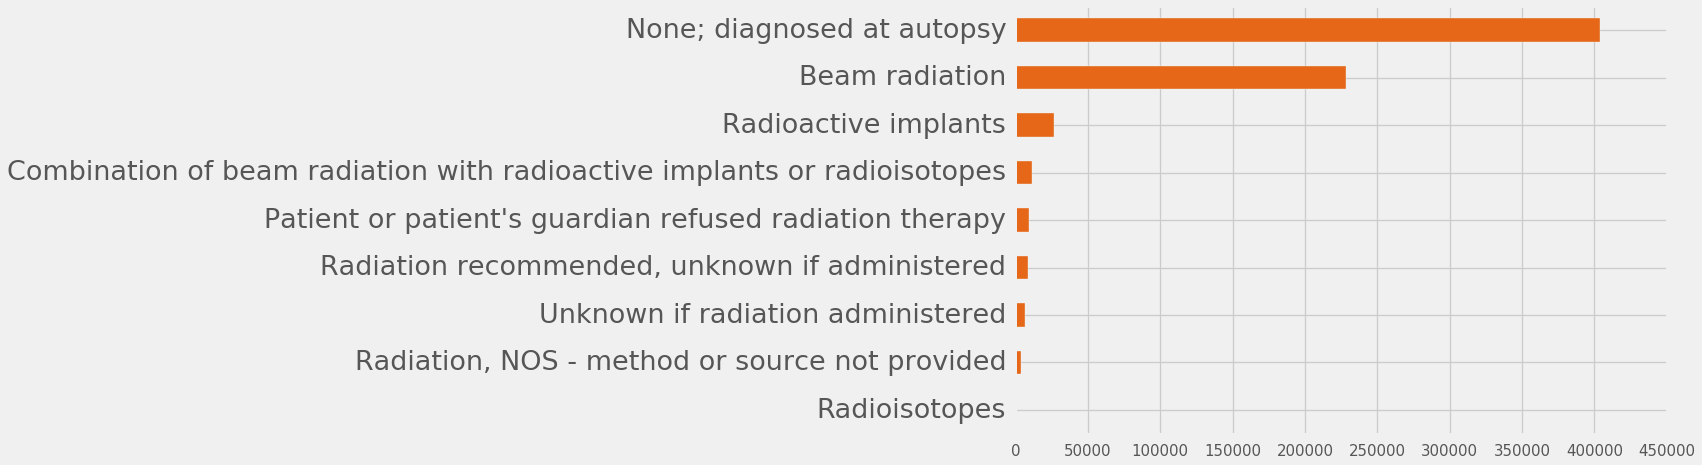

In [33]:
ax = dfall.rad1.value_counts()[::-1].plot(kind='barh',color='#E56717')
ax.yaxis.set_tick_params(labelsize=27)
ax.xaxis.set_tick_params(labelsize=15)

In [34]:
one = ~non_rad1 & ~refused_rad1 & ~unknown_rad1

had_rad = one

dfsmall = dfall[had_rad].copy()

In [35]:
dfsmall.shape

(270567, 496)

In [36]:
smalltreatmentindices = dfsmall[dfsmall.patient_id.isin(puretreatmentindices)].index
smallcontrolindices = dfsmall[dfsmall.patient_id.isin(purecontrolindices)].index

In [37]:
smallcontrolindices.shape

(47304,)

In [38]:
smalltreatmentindices.shape

(1138,)

In [39]:
set(smalltreatmentindices).issubset(puretreatmentindices) 

True

In [40]:
set(smallcontrolindices).issubset(purecontrolindices)

True

In [41]:
dfalltreatment = dfsmall.loc[smalltreatmentindices].copy()
dfallcontrol = dfsmall.loc[smallcontrolindices].copy()

In [42]:
dfalltreatment.shape, dfallcontrol.shape

((1138, 496), (47304, 496))

# <font color="#E56717">So we are going to match patients who have received PBT (1138 of them) with the 47304 patients who have received IMRT as their first course of treatment. These patients have been identified as receiving RT treatment delivery in both halves of the SEER-Medicare data</font>

<span style="font-size:1.5em;">We first need to deide on which features (or columns) of the data to use to define the feature space; and then do some preprocessing of this data ("one-hot-encode" the categorical features)</span>

In [43]:
cstum1mask =  (dfsmall['cstum1'] != "Unknown; size not stated; not stated in patient record") & \
(dfsmall['cstum1'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfsmall['cstum1'] != "989 millimeters or larger") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != "Unknown age") & \
(dfsmall['cstum1'] != "Described as less than 1 cm") & \
(dfsmall['cstum1'] != "Described as less than 2 cm") & \
(dfsmall['cstum1'] != "Described as less than 3 cm") & \
(dfsmall['cstum1'] != 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfsmall['cstum1'] != "Described as less than 4 cm") & \
(dfsmall['cstum1'] != "Described as less than 5 cm") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != 'Not applicable') & \
(dfsmall['cstum1'] != 996) & \
(dfsmall['cstum1'] != 997) & \
(dfsmall['cstum1'] != 998) & \
(dfsmall['srvm1'] != 9999)

# <font color="#E56717">We will not include the variable cstum1 (the tumor size in mm) for the following reasons:</font>

* <span style="font-size:1.5em;">Egregious measurement error</span>
* <span style="font-size:1.5em;">Over half of the patients have missing values, or text values instead of numbers</span>

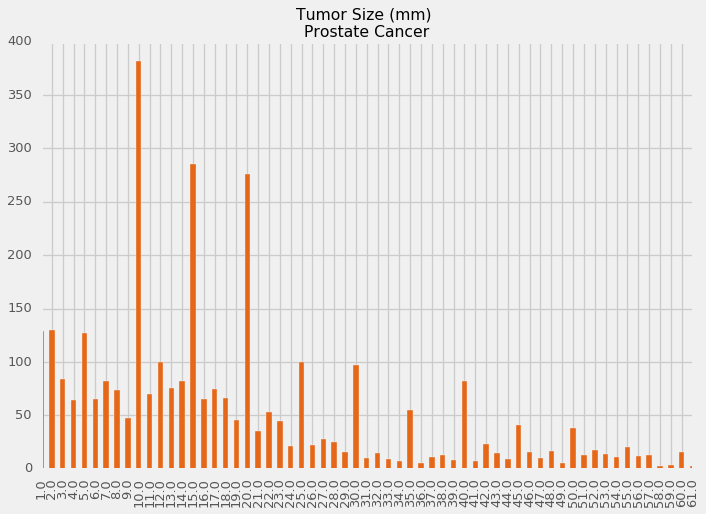

In [44]:
dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",
case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nProstate Cancer',color='#E56717');
plt.xlim(0,60);

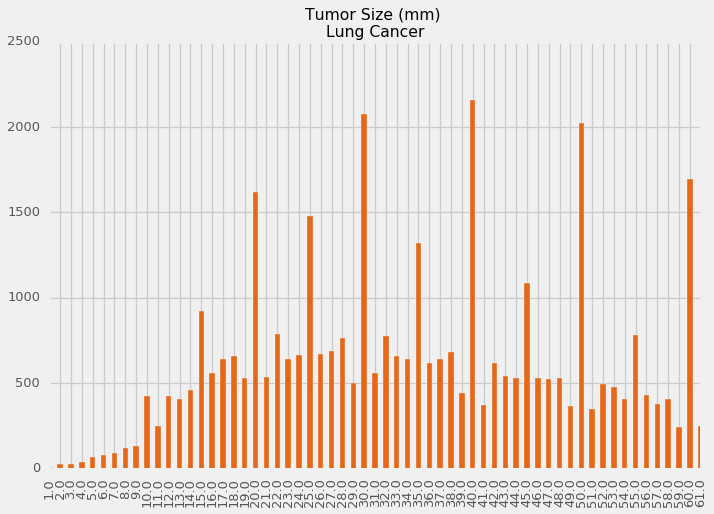

In [45]:
fig1 = plt.figure()
ax = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,
na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nLung Cancer',color='#E56717');
plt.xlim(0,60);

# <font color="#E56717">This phenomena is so common it has a name</font>

# End-digit preference

<span style="font-size:1.5em;">"In converting analog to digital data, observers may record some terminal digits with an unusual frequency, for example rounding off may be to the nearest whole number, even number, multiple of 5 or 10, or when time units like a week are involved, 7, 14, etc."</span>

* <span style="font-size:1.2em;">Encyclopedia of Epidemiologic Methods, by By Mitchell H. Gail, Jacques Benichou</span>

In [46]:
dfalltreatment['class'] = 'PBT'
dfallcontrol['class'] = 'IMRT'

# <font color="#E56717">Need to include the chemo information</font> 

<span style="font-size:1.5em;">Make a ```chemo``` column that is 1 if the patient received chemo, 0 otherwise</span>

In [47]:
dfalltreatment['chemo'] = 0
dfallcontrol['chemo'] = 0

In [48]:
bigchemo_dict = {k: 1 for k in bigchemoindices}
bigchemo_dict['0'] = 0

In [49]:
dfalltreatment['chemo'] = dfalltreatment['patient_id'].replace(bigchemo_dict)

In [50]:
dfallcontrol['chemo'] = dfallcontrol['patient_id'].replace(bigchemo_dict)

In [51]:
(dfalltreatment['chemo'] == 1).sum()

287

In [52]:
(dfallcontrol['chemo'] == 1).sum()

23271

In [53]:
dfalltreatment['chemo'] = (dfalltreatment['chemo'] == 1).astype('int')

In [54]:
dfallcontrol['chemo'] = (dfallcontrol['chemo'] == 1).astype('int')

In [55]:
dfalltreatment['chemo'].value_counts(normalize=True)

0    0.747803
1    0.252197
Name: chemo, dtype: float64

In [56]:
dfallcontrol['chemo'].value_counts(normalize=True)

0    0.508054
1    0.491946
Name: chemo, dtype: float64

In [57]:
dfalltreatment['dajcct1'].isnull().sum()

0

In [58]:
dfallcontrol['dajcct1'].isnull().sum() # maybe drop these guys

0

In [59]:
dfalltreatment['dajccn1'].isnull().sum()

0

In [60]:
dfallcontrol['dajccn1'].isnull().sum()

0

In [61]:
dfalltreatment['dajccm1'].isnull().sum()

0

In [62]:
dfallcontrol['dajccm1'].isnull().sum()

0

In [63]:
dfalltreatment['dajccstg1'].isnull().sum()

0

In [64]:
dfallcontrol['dajccstg1'].isnull().sum()

0

In [65]:
dfallcontrol.shape

(47304, 498)

In [66]:
#catcols = ['m_sex','marst1','srace','nhiade','grade1',
#           'site1','lat1',
#          'histrec1','dajcct1','dajccn1','dajccm1','dajccstg1',
#           'chemo',
#           'modx1','stat_rec']

catcols = ['m_sex','marst1','srace','nhiade','grade1',
           'site1','lat1',
          'histrec1','dajccstg1',
           'chemo',
           'modx1','stat_rec']


goodcols = ['m_sex','marst1', 'srace','nhiade',
           'grade1','site1',
           'lat1','histrec1','dajccstg1',
            'chemo',
           'modx1','stat_rec','birthyr',
           'agedx1',
           'yrdx1','elevation_1',
           'lng_1','lat_1']

In [67]:
dfpop = pd.concat([dfallcontrol, dfalltreatment])

In [68]:
resgoodcontrol = pd.concat([pd.get_dummies(dfallcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfalltreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

In [69]:
print(goodcols)

['m_sex', 'marst1', 'srace', 'nhiade', 'grade1', 'site1', 'lat1', 'histrec1', 'dajccstg1', 'chemo', 'modx1', 'stat_rec', 'birthyr', 'agedx1', 'yrdx1', 'elevation_1', 'lng_1', 'lat_1']


In [70]:
resgoodcontrol['birthyr'] = dfallcontrol['birthyr']
resgoodcontrol['agedx1'] = dfallcontrol['agedx1']

resgoodcontrol['yrdx1'] = dfallcontrol['yrdx1']


resgoodcontrol['lat_1'] = dfallcontrol['lat_1']

resgoodcontrol['lng_1'] = dfallcontrol['lng_1']

resgoodcontrol['srvm1'] = dfallcontrol['srvm1']

resgoodcontrol['elevation_1'] = dfallcontrol['elevation_1']

In [71]:
resgoodtreatment['birthyr'] = dfalltreatment['birthyr']
resgoodtreatment['agedx1'] = dfalltreatment['agedx1']

resgoodtreatment['yrdx1'] = dfalltreatment['yrdx1']


resgoodtreatment['lat_1'] = dfalltreatment['lat_1']

resgoodtreatment['lng_1'] = dfalltreatment['lng_1']

resgoodtreatment['srvm1'] = dfalltreatment['srvm1']

resgoodtreatment['elevation_1'] = dfalltreatment['elevation_1']

In [72]:
resgoodpop['birthyr'] = dfpop['birthyr']
resgoodpop['agedx1'] = dfpop['agedx1']

resgoodpop['yrdx1'] = dfpop['yrdx1']




resgoodpop['lat_1'] = dfpop['lat_1']

resgoodpop['lng_1'] = dfpop['lng_1']

resgoodpop['srvm1'] = dfpop['srvm1']

resgoodpop['elevation_1'] = dfpop['elevation_1']

In [73]:
resgoodpop['birthyr'] = resgoodpop['birthyr'].astype('int')
resgoodpop['agedx1'] = resgoodpop['agedx1'].astype('float')



resgoodpop['lat_1'] = resgoodpop['lat_1'].astype('float')



resgoodpop['lng_1'] = resgoodpop['lng_1'].astype('float')
resgoodpop['elevation_1'] = resgoodpop['elevation_1'].astype('float')

resgoodpop['srvm1'] = resgoodpop['srvm1'].astype('float')


newcolumns = list(resgoodpop.columns)

newcolumns.remove('srvm1')
newcolumns.remove('stat_rec_Alive')
newcolumns.remove('stat_rec_Dead')
newcolumns.remove('m_sex_Male')

resgreatpop = resgoodpop[newcolumns].copy()

In [74]:
resgreatpop['patient_id'] = resgreatpop.index
leaguefilter = (resgreatpop['patient_id'].loc[smalltreatmentindices])
resgreatpop['League'] = resgreatpop['patient_id'].isin(smalltreatmentindices).astype('int')
del resgreatpop['patient_id']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
#del dftree['League']

In [75]:
resgreatpop['League'].value_counts()

0    47304
1     1138
Name: League, dtype: int64

# <font color="#E56717">Before Matching, let's look at the distribution of PBT and IMRT patients in the reduced-dimensional feature space by using PCA</font>

In [76]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

In [77]:
del dftree['League']
print(list(dftree.columns))

['m_sex_Female', 'marst1_Divorced', 'marst1_Married (including common law)', 'marst1_Separated', 'marst1_Single (never married)', 'marst1_Unknown', 'marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered)', 'marst1_Widowed', 'srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)', 'srace_Asian Indian', 'srace_Asian Indian or Pakistani, NOS', 'srace_Black', 'srace_Chinese', 'srace_Fiji Islander', 'srace_Filipino', 'srace_Guamanian, NOS', 'srace_Hawaiian', 'srace_Hmong', 'srace_Japanese', 'srace_Kampuchean (including Khmer and Cambodian)', 'srace_Korean', 'srace_Laotian', 'srace_Melanesian, NOS', 'srace_Micronesian, NOS', 'srace_Other', 'srace_Other Asian, including Asian, NOS and Oriental NOS', 'srace_Pacific Islander, NOS', 'srace_Pakistani', 'srace_Polynesian, NOS', 'srace_Samoan', 'srace_Thai', 'srace_Tongan', 'srace_Unknown', 'srace_Vietnamese', 'srace_White', 'nhiade_Cuban', 'nhiade_Dominica

In [78]:
dftree.shape

(48442, 206)

In [79]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
print(xTrain)

[[ 1.86037633 -0.27669597 -1.33933469 ...,  0.91824391  1.1257822
   0.2399756 ]
 [-0.53752565 -0.27669597  0.74663936 ...,  0.81755514  1.14990121
  -0.57241686]
 [-0.53752565 -0.27669597 -1.33933469 ...,  0.84889531  1.16681248
  -0.66185617]
 ..., 
 [ 1.86037633 -0.27669597  0.74663936 ..., -0.57640146 -1.07760396
   1.53811568]
 [ 1.86037633 -0.27669597  0.74663936 ..., -0.79661364 -1.1274874
   0.03552042]
 [ 1.86037633 -0.27669597  0.74663936 ..., -0.57640146 -1.07760396
   1.53811568]]


In [80]:
dfscaled = pd.DataFrame(xTrain,index=dftree.index)
dfscaled.columns = dftree.columns
dfscaled.head()

,m_sex_Female,marst1_Divorced,marst1_Married (including common law),marst1_Separated,marst1_Single (never married),marst1_Unknown,marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered),marst1_Widowed,"srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",srace_Asian Indian,...,modx1_May,modx1_Nov,modx1_Oct,modx1_Sep,birthyr,agedx1,yrdx1,lat_1,lng_1,elevation_1
patient_id,,,,,,,,,,,,,,,,,,,,,
0232466001,1.860376,-0.276696,-1.339335,-0.085555,-0.311592,-0.270507,-0.013632,2.674154,-0.05247,-0.03964,...,-0.309435,-0.288494,-0.302942,-0.29491,0.146921,0.167725,1.694882,0.918244,1.125782,0.239976
0237405040,-0.537526,-0.276696,0.746639,-0.085555,-0.311592,-0.270507,-0.013632,-0.373950,-0.05247,-0.03964,...,-0.309435,3.466273,-0.302942,-0.29491,-1.658866,1.449669,-1.427042,0.817555,1.149901,-0.572417
0239435040,-0.537526,-0.276696,-1.339335,-0.085555,3.209321,-0.270507,-0.013632,-0.373950,-0.05247,-0.03964,...,-0.309435,-0.288494,3.300964,-0.29491,1.119268,-1.399094,-1.427042,0.848895,1.166812,-0.661856
0242412040,-0.537526,3.614075,-1.339335,-0.085555,-0.311592,-0.270507,-0.013632,-0.373950,-0.05247,-0.03964,...,-0.309435,-0.288494,-0.302942,-0.29491,1.952708,-2.253723,-0.802657,0.848895,1.166812,-0.661856
0243456001,1.860376,-0.276696,-1.339335,-0.085555,-0.311592,-0.270507,-0.013632,2.674154,-0.05247,-0.03964,...,-0.309435,-0.288494,-0.302942,-0.29491,-0.964332,1.449669,1.694882,0.919515,1.149901,-0.001520


In [81]:

dfnewscaled = dfscaled.copy()
dfscaled['League'] = y
dfscaled.head()

,m_sex_Female,marst1_Divorced,marst1_Married (including common law),marst1_Separated,marst1_Single (never married),marst1_Unknown,marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered),marst1_Widowed,"srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",srace_Asian Indian,...,modx1_Nov,modx1_Oct,modx1_Sep,birthyr,agedx1,yrdx1,lat_1,lng_1,elevation_1,League
patient_id,,,,,,,,,,,,,,,,,,,,,
0232466001,1.860376,-0.276696,-1.339335,-0.085555,-0.311592,-0.270507,-0.013632,2.674154,-0.05247,-0.03964,...,-0.288494,-0.302942,-0.29491,0.146921,0.167725,1.694882,0.918244,1.125782,0.239976,0
0237405040,-0.537526,-0.276696,0.746639,-0.085555,-0.311592,-0.270507,-0.013632,-0.373950,-0.05247,-0.03964,...,3.466273,-0.302942,-0.29491,-1.658866,1.449669,-1.427042,0.817555,1.149901,-0.572417,0
0239435040,-0.537526,-0.276696,-1.339335,-0.085555,3.209321,-0.270507,-0.013632,-0.373950,-0.05247,-0.03964,...,-0.288494,3.300964,-0.29491,1.119268,-1.399094,-1.427042,0.848895,1.166812,-0.661856,0
0242412040,-0.537526,3.614075,-1.339335,-0.085555,-0.311592,-0.270507,-0.013632,-0.373950,-0.05247,-0.03964,...,-0.288494,-0.302942,-0.29491,1.952708,-2.253723,-0.802657,0.848895,1.166812,-0.661856,0
0243456001,1.860376,-0.276696,-1.339335,-0.085555,-0.311592,-0.270507,-0.013632,2.674154,-0.05247,-0.03964,...,-0.288494,-0.302942,-0.29491,-0.964332,1.449669,1.694882,0.919515,1.149901,-0.001520,0


In [82]:
# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [83]:
from __future__ import division, print_function
from __future__ import absolute_import, unicode_literals

# Our numerical workhorses
import numpy as np
import pandas as pd

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# We'll use Pybeeswarm
import beeswarm as bs

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

C:\Users\ddooling\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\pylab\config.py:78: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


Loading BokehJS ...

In [84]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.stats as st

# Import pyplot for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

# Seaborn, useful for graphics
import seaborn as sns

# Package to perform PCA
import sklearn.datasets
import sklearn.decomposition

# Utilities for our class
#import bebi103

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Loading BokehJS ...

In [85]:
print(resgreatpop.columns)

Index(['m_sex_Female', 'marst1_Divorced',
       'marst1_Married (including common law)', 'marst1_Separated',
       'marst1_Single (never married)', 'marst1_Unknown',
       'marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered)',
       'marst1_Widowed',
       'srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)',
       'srace_Asian Indian',
       ...
       'modx1_Nov', 'modx1_Oct', 'modx1_Sep', 'birthyr', 'agedx1', 'yrdx1',
       'lat_1', 'lng_1', 'elevation_1', 'League'],
      dtype='object', length=207)


In [86]:
# calculate the principal components using scikit-learn
sklearn_pca = sklearn.decomposition.PCA()
sklearn_pca.fit(resgreatpop[list(resgreatpop.columns)[:-1]])
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)

Variance percent explained
 [  9.99646206e-01   2.60446376e-04   7.26737131e-05   1.39114134e-05
   2.81167401e-06   8.27732377e-07   4.02137495e-07   2.36331462e-07
   2.11282637e-07   1.51850802e-07   1.50601522e-07   1.24652529e-07
   1.02861145e-07   7.25865862e-08   7.03731726e-08   6.74135084e-08
   6.60321866e-08   6.43473020e-08   6.31283968e-08   6.27312294e-08
   6.16867564e-08   6.02229734e-08   6.00293789e-08   5.88780399e-08
   5.79893522e-08   5.74493730e-08   5.54546193e-08   5.27893425e-08
   5.25824222e-08   4.95859888e-08   4.56924941e-08   4.06676340e-08
   3.75819078e-08   3.31476914e-08   3.06812011e-08   2.99140526e-08
   2.90811376e-08   2.69178800e-08   2.57493107e-08   2.39610577e-08
   2.00274336e-08   1.96047484e-08   1.86660434e-08   1.69529722e-08
   1.64603925e-08   1.54616957e-08   1.43045732e-08   1.40629566e-08
   1.25807998e-08   1.10935958e-08   1.05888081e-08   9.00664645e-09
   8.47050448e-09   7.93270802e-09   7.60850326e-09   7.53442632e-09
   7.3

In [87]:
# Perform the PCA again retaining only the top 2 components
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2,whiten=True)
sklearn_pca.fit(resgreatpop[list(resgreatpop.columns)[:-1]])

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(resgreatpop[list(resgreatpop.columns)[:-1]]),
                     columns=['PCA1', 'PCA2'],index=resgreatpop.index)
df_2D['League'] = resgreatpop['League'].copy()
df_2D.head()

,PCA1,PCA2,League
patient_id,,,
0232466001,-0.239886,-1.246097,0
0237405040,0.572493,-1.023511,0
0239435040,0.661929,-1.050747,0
0242412040,0.661929,-1.061079,0
0243456001,0.001608,-1.189001,0


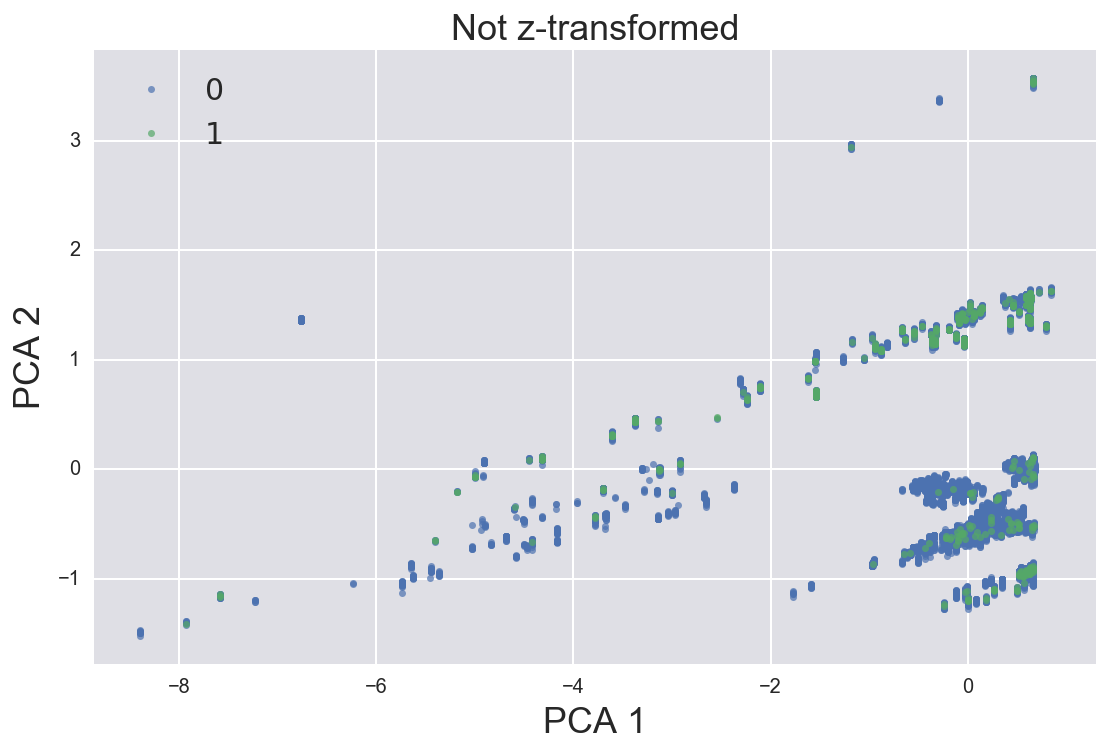

In [88]:
for key, group in df_2D.groupby(['League']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, 
             ms=3.5,label=key)

# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Not z-transformed')

In [89]:
df_2D['m_sex'] = dfpop['m_sex']
df_2D['marst1'] = dfpop['marst1']
df_2D['srace'] = dfpop['srace']
df_2D['nhiade'] = dfpop['nhiade']
df_2D['grade1'] = dfpop['grade1']
df_2D['site1'] = dfpop['site1']
df_2D['lat1'] = dfpop['lat1']
df_2D['histrec1'] = dfpop['histrec1']
df_2D['modx1'] = dfpop['modx1']
df_2D['birthyr'] = dfpop['birthyr']
df_2D['agedx1'] = dfpop['agedx1']
df_2D['yrdx1'] = dfpop['yrdx1']
df_2D['elevation_1'] = dfpop['elevation_1']
df_2D['lng_1'] = dfpop['lng_1']
df_2D['lat_1'] = dfpop['lat_1']
df_2D['chemo'] = dfpop['chemo']
df_2D['dajcct1'] = dfpop['dajcct1']
df_2D['dajccn1'] = dfpop['dajccn1']
df_2D['dajccm1'] = dfpop['dajccm1']
df_2D['dajccstg1'] = dfpop['dajccstg1']

In [90]:
df_2D.head()

,PCA1,PCA2,League,m_sex,marst1,srace,nhiade,grade1,site1,lat1,...,agedx1,yrdx1,elevation_1,lng_1,lat_1,chemo,dajcct1,dajccn1,dajccm1,dajccstg1
patient_id,,,,,,,,,,,,,,,,,,,,,
0232466001,-0.239886,-1.246097,0,Female,Widowed,White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Lateral wall of nasopharynx,Left: origin of primary,...,73,2011,1066.803253,-73.276536,41.786629,1,T4,N0,M0,Stage IVA
0237405040,0.572493,-1.023511,0,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade IV; grade iv; grade 4; undifferentaited;...,"Nasopharynx, NOS",Not a paired site,...,82,2006,115.878780,-72.804280,41.326691,1,T2b,NX,MX,Stage Unknown
0239435040,0.661929,-1.050747,0,Male,Single (never married),White,Non-Spanish-Hispanic-Latino,Grade IV; grade iv; grade 4; undifferentaited;...,Posterior wall of nasopharynx,Not a paired site,...,62,2006,11.187957,-72.473153,41.469851,1,T4,N1,M0,Stage IVA
0242412040,0.661929,-1.061079,0,Male,Divorced,White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Posterior wall of nasopharynx,Not a paired site,...,56,2007,11.187957,-72.473153,41.469851,1,T4,N1,M0,Stage IVA
0243456001,0.001608,-1.189001,0,Female,Widowed,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...","Nasopharynx, NOS",Left: origin of primary,...,82,2011,784.126417,-72.804280,41.792434,1,T2b,N0,M0,Stage IIB


In [91]:
for key, group in df_2D.groupby(['League']):
    print(key, group.shape)

0 (47304, 23)
1 (1138, 23)


In [92]:
dfscaled.shape

(48442, 207)

In [93]:
# Perform the PCA again retaining only the top 2 components
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=3,whiten=True)
sklearn_pca.fit(dfscaled[list(dfscaled.columns)[:-1]])

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(dfscaled[list(dfscaled.columns)[:-1]]),
                     columns=['PCA1', 'PCA2','PCA3'],index=dfscaled.index)
df_2D['League'] = dfscaled['League'].copy()
df_2D.head()

,PCA1,PCA2,PCA3,League
patient_id,,,,
0232466001,-1.409266,0.392732,-1.805314,0
0237405040,-0.504094,1.388386,-1.290511,0
0239435040,-0.694831,1.330782,-1.457806,0
0242412040,-0.557848,0.616686,-1.715462,0
0243456001,-1.650080,0.700426,-1.917709,0


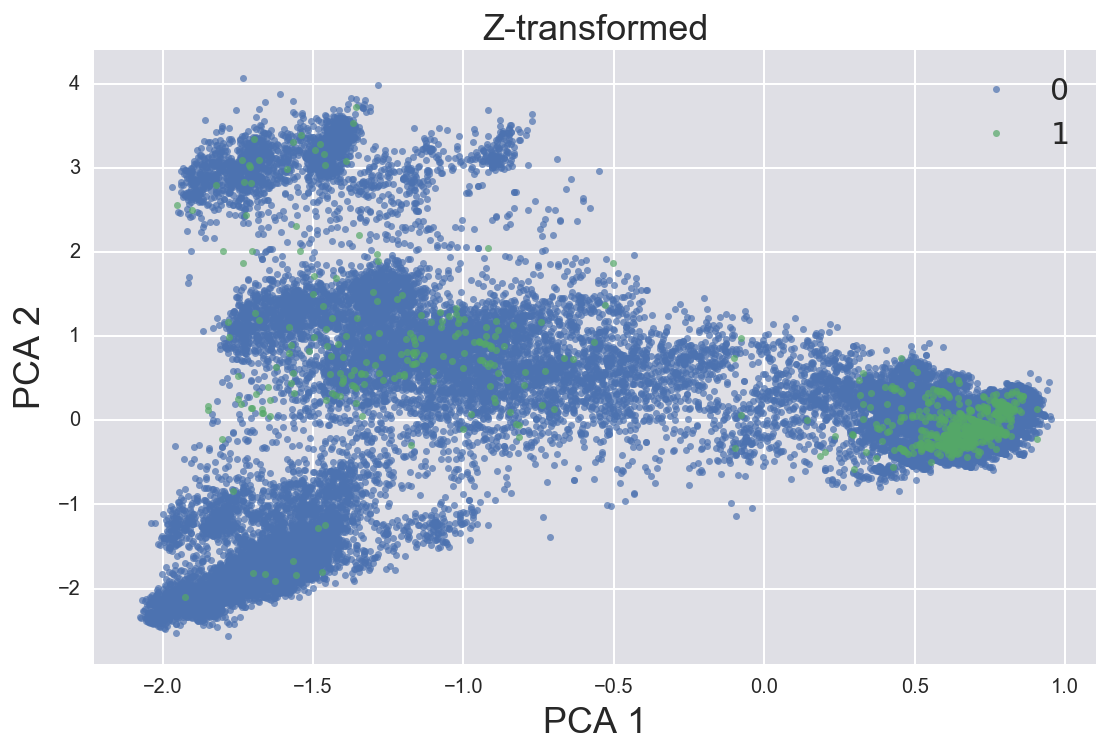

In [94]:
for key, group in df_2D.groupby(['League']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key,
            ms=3.5)#

# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Z-transformed')

In [95]:
dfscaled.shape, dfpop.shape

((48442, 207), (48442, 498))

In [96]:
#dfpop.head()

In [97]:
df_2D['m_sex'] = dfpop['m_sex']
df_2D['marst1'] = dfpop['marst1']
df_2D['srace'] = dfpop['srace']
df_2D['nhiade'] = dfpop['nhiade']
df_2D['grade1'] = dfpop['grade1']
df_2D['site1'] = dfpop['site1']
df_2D['lat1'] = dfpop['lat1']
df_2D['histrec1'] = dfpop['histrec1']
df_2D['modx1'] = dfpop['modx1']
df_2D['birthyr'] = dfpop['birthyr']
df_2D['agedx1'] = dfpop['agedx1']
df_2D['yrdx1'] = dfpop['yrdx1']
df_2D['elevation_1'] = dfpop['elevation_1']
df_2D['lng_1'] = dfpop['lng_1']
df_2D['lat_1'] = dfpop['lat_1']
df_2D['chemo'] = dfpop['chemo']
df_2D['dajcct1'] = dfpop['dajcct1']
df_2D['dajccstg1'] = dfpop['dajccstg1']
df_2D['countystate_1'] = dfpop['countystate_1']

In [98]:
dfpop.countystate_1.head()

patient_id
0232466001    Litchfield County, CT
0237405040     New Haven County, CT
0239435040     Middlesex County, CT
0242412040     Middlesex County, CT
0243456001      Hartford County, CT
Name: countystate_1, dtype: object

In [99]:
df_2D.head()

,PCA1,PCA2,PCA3,League,m_sex,marst1,srace,nhiade,grade1,site1,...,birthyr,agedx1,yrdx1,elevation_1,lng_1,lat_1,chemo,dajcct1,dajccstg1,countystate_1
patient_id,,,,,,,,,,,,,,,,,,,,,
0232466001,-1.409266,0.392732,-1.805314,0,Female,Widowed,White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Lateral wall of nasopharynx,...,1937,73,2011,1066.803253,-73.276536,41.786629,1,T4,Stage IVA,"Litchfield County, CT"
0237405040,-0.504094,1.388386,-1.290511,0,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade IV; grade iv; grade 4; undifferentaited;...,"Nasopharynx, NOS",...,1924,82,2006,115.878780,-72.804280,41.326691,1,T2b,Stage Unknown,"New Haven County, CT"
0239435040,-0.694831,1.330782,-1.457806,0,Male,Single (never married),White,Non-Spanish-Hispanic-Latino,Grade IV; grade iv; grade 4; undifferentaited;...,Posterior wall of nasopharynx,...,1944,62,2006,11.187957,-72.473153,41.469851,1,T4,Stage IVA,"Middlesex County, CT"
0242412040,-0.557848,0.616686,-1.715462,0,Male,Divorced,White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Posterior wall of nasopharynx,...,1950,56,2007,11.187957,-72.473153,41.469851,1,T4,Stage IVA,"Middlesex County, CT"
0243456001,-1.650080,0.700426,-1.917709,0,Female,Widowed,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...","Nasopharynx, NOS",...,1929,82,2011,784.126417,-72.804280,41.792434,1,T2b,Stage IIB,"Hartford County, CT"


In [100]:
for key, group in df_2D.groupby(['League']):
    print(key, group.shape)

0 (47304, 23)
1 (1138, 23)


In [101]:
# what pops up on hover?
#tooltips = [('m_sex', '@m_sex'),
#           ('marst1', '@marst1'),
#           ('srace', '@srace'),
#           ('grade1', '@grade1'),
#           ('site1', '@site1'),
#           ('birthyr', '@birthyr'),
#           ('agedx1', 'agedx1'),
#           ('yrdx1', '@yrdx1'),
#           ('dajccstg1', '@dajccstg1'),
#           ('countystate_1', '@countystate_1')]

# make the hover tool
#hover = bokeh.models.HoverTool(tooltips=tooltips)

#from matplotlib import cm
#cmap = cm.get_cmap('Spectral')



# Create figure
#p = bokeh.plotting.figure(background_fill_color="#DFDFE5", plot_width=650,
#                         plot_height=450)
#p.xgrid.grid_line_color = 'white'
#p.ygrid.grid_line_color = 'white'
#p.xaxis.axis_label = 'PC 1'
#p.yaxis.axis_label = 'PC 2'

# Add the hover tool
#p.add_tools(hover)

# define colors in a dictionary to access them with 
# the key from the pandas group by function

#color_dict = {0: 'blue',
#             1: 'green'}

#sklearn_pca = sklearn.decomposition.PCA(n_components=2)
#sklearn_pca.fit(df_iris[list(df_iris.columns)[:-1]])

# Project the data into this 2D space and convert it back to a tidy dataframe
#df_2D = pd.DataFrame(sklearn_pca.transform(df_iris[list(df_iris.columns)[:-1]]),
#                     columns=['PCA1', 'PCA2'])
#df_2D['species'] = df_iris['species']
#df_2D['sepalLength'] = df_iris['sepalLength']
#df_2D['sepalWidth'] = df_iris['sepalWidth']
#df_2D['petalLength'] = df_iris['petalLength']
#df_2D['petalWidth'] = df_iris['petalWidth']

#for key, group in df_2D.groupby(['League']):
#    # specify data source
#    source = bokeh.models.ColumnDataSource(group)
    
    # populate glyphs
#    p.circle(x='PCA1', y='PCA2', size=4, source=source,
#            alpha=0.2,color=color_dict[key],
#            legend=str(key))
    
#p.legend.background_fill_alpha = 0.25
#p.legend.background_fill_color = 'blanchedalmond'
#bokeh.plotting.output_file("pca_update.html")
#bokeh.io.show(p)

In [102]:
print(list(dftree.columns))

['m_sex_Female', 'marst1_Divorced', 'marst1_Married (including common law)', 'marst1_Separated', 'marst1_Single (never married)', 'marst1_Unknown', 'marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered)', 'marst1_Widowed', 'srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)', 'srace_Asian Indian', 'srace_Asian Indian or Pakistani, NOS', 'srace_Black', 'srace_Chinese', 'srace_Fiji Islander', 'srace_Filipino', 'srace_Guamanian, NOS', 'srace_Hawaiian', 'srace_Hmong', 'srace_Japanese', 'srace_Kampuchean (including Khmer and Cambodian)', 'srace_Korean', 'srace_Laotian', 'srace_Melanesian, NOS', 'srace_Micronesian, NOS', 'srace_Other', 'srace_Other Asian, including Asian, NOS and Oriental NOS', 'srace_Pacific Islander, NOS', 'srace_Pakistani', 'srace_Polynesian, NOS', 'srace_Samoan', 'srace_Thai', 'srace_Tongan', 'srace_Unknown', 'srace_Vietnamese', 'srace_White', 'nhiade_Cuban', 'nhiade_Dominica

In [103]:
print(xTrain)

[[ 1.86037633 -0.27669597 -1.33933469 ...,  0.91824391  1.1257822
   0.2399756 ]
 [-0.53752565 -0.27669597  0.74663936 ...,  0.81755514  1.14990121
  -0.57241686]
 [-0.53752565 -0.27669597 -1.33933469 ...,  0.84889531  1.16681248
  -0.66185617]
 ..., 
 [ 1.86037633 -0.27669597  0.74663936 ..., -0.57640146 -1.07760396
   1.53811568]
 [ 1.86037633 -0.27669597  0.74663936 ..., -0.79661364 -1.1274874
   0.03552042]
 [ 1.86037633 -0.27669597  0.74663936 ..., -0.57640146 -1.07760396
   1.53811568]]


# <font color="#E56717">Before matching, let's get the KM curves for prostate</font>

In [104]:
from sklearn.neighbors import KDTree

In [105]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

# <font color="#E56717">Here is a video explaining the construction of a KDTree</font>

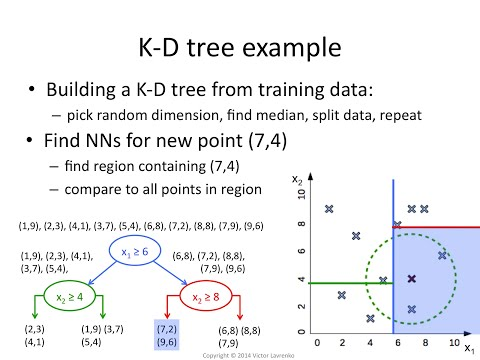

In [106]:
from IPython.display import YouTubeVideo
YouTubeVideo('Y4ZgLlDfKDg')

In [107]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=11, return_distance=True)

# <font color="#E56717">Finding the distance to all of the 5 nearest neighbors only took 4 minutes!</font>

In [108]:
dftreeleague.head()

,m_sex_Female,marst1_Divorced,marst1_Married (including common law),marst1_Separated,marst1_Single (never married),marst1_Unknown,marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered),marst1_Widowed,"srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",srace_Asian Indian,...,modx1_Nov,modx1_Oct,modx1_Sep,birthyr,agedx1,yrdx1,lat_1,lng_1,elevation_1,League
patient_id,,,,,,,,,,,,,,,,,,,,,
0232466001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1937,73.0,2011,41.786629,-73.276536,1066.803253,0
0237405040,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1924,82.0,2006,41.326691,-72.804280,115.878780,0
0239435040,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1944,62.0,2006,41.469851,-72.473153,11.187957,0
0242412040,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1950,56.0,2007,41.469851,-72.473153,11.187957,0
0243456001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1929,82.0,2011,41.792434,-72.804280,784.126417,0


In [109]:
dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['neighbor_4'] = pd.Series(ind4[:,4],index=dftreeleague.index)
dftreeleague['neighbor_5'] = pd.Series(ind4[:,5],index=dftreeleague.index)
dftreeleague['neighbor_6'] = pd.Series(ind4[:,6],index=dftreeleague.index)
dftreeleague['neighbor_7'] = pd.Series(ind4[:,7],index=dftreeleague.index)
dftreeleague['neighbor_8'] = pd.Series(ind4[:,8],index=dftreeleague.index)
dftreeleague['neighbor_9'] = pd.Series(ind4[:,9],index=dftreeleague.index)
dftreeleague['neighbor_10'] = pd.Series(ind4[:,10],index=dftreeleague.index)

dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)
dftreeleague['distance_4'] = pd.Series(dist4[:,4],index=dftreeleague.index)
dftreeleague['distance_5'] = pd.Series(dist4[:,5],index=dftreeleague.index)
dftreeleague['distance_6'] = pd.Series(dist4[:,6],index=dftreeleague.index)
dftreeleague['distance_7'] = pd.Series(dist4[:,7],index=dftreeleague.index)
dftreeleague['distance_8'] = pd.Series(dist4[:,8],index=dftreeleague.index)
dftreeleague['distance_9'] = pd.Series(dist4[:,9],index=dftreeleague.index)
dftreeleague['distance_10'] = pd.Series(dist4[:,10],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}

In [110]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)
dftreeleague['neighbor_4'] = dftreeleague['neighbor_4'].apply(get_pubcsnum)
dftreeleague['neighbor_5'] = dftreeleague['neighbor_5'].apply(get_pubcsnum)
dftreeleague['neighbor_6'] = dftreeleague['neighbor_6'].apply(get_pubcsnum)
dftreeleague['neighbor_7'] = dftreeleague['neighbor_7'].apply(get_pubcsnum)
dftreeleague['neighbor_8'] = dftreeleague['neighbor_8'].apply(get_pubcsnum)
dftreeleague['neighbor_9'] = dftreeleague['neighbor_9'].apply(get_pubcsnum)
dftreeleague['neighbor_10'] = dftreeleague['neighbor_10'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)
dftreeleague['neighbor_4_League'] = dftreeleague['neighbor_4'].apply(get_league)
dftreeleague['neighbor_5_League'] = dftreeleague['neighbor_5'].apply(get_league)
dftreeleague['neighbor_6_League'] = dftreeleague['neighbor_6'].apply(get_league)
dftreeleague['neighbor_7_League'] = dftreeleague['neighbor_7'].apply(get_league)
dftreeleague['neighbor_8_League'] = dftreeleague['neighbor_8'].apply(get_league)
dftreeleague['neighbor_9_League'] = dftreeleague['neighbor_9'].apply(get_league)
dftreeleague['neighbor_10_League'] = dftreeleague['neighbor_10'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 0)

dist1filter = (dftreeleague['distance_1'] <= 5)
dist2filter = (dftreeleague['distance_2'] <= 5)
dist3filter = (dftreeleague['distance_3'] <= 5)
dist4filter = (dftreeleague['distance_4'] <= 5)
dist5filter = (dftreeleague['distance_5'] <= 5)
dist6filter = (dftreeleague['distance_6'] <= 5)
dist7filter = (dftreeleague['distance_7'] <= 5)
dist8filter = (dftreeleague['distance_8'] <= 5)
dist9filter = (dftreeleague['distance_9'] <= 5)
dist10filter = (dftreeleague['distance_10'] <= 5)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 0)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 0)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()


neighbor_4_match = (dftreeleague['neighbor_4_League'] == 0)

four = dftreeleague[['neighbor_4','distance_4',
                  'neighbor_4_League'
]][(dftreeleague['neighbor_4_League'] != dftreeleague['League']) & (neighbor_4_match) & (dist4filter) ].copy()


neighbor_5_match = (dftreeleague['neighbor_5_League'] == 0)

five = dftreeleague[['neighbor_5','distance_5',
                  'neighbor_5_League'
]][(dftreeleague['neighbor_5_League'] != dftreeleague['League']) & (neighbor_5_match) & (dist5filter) ].copy()


##############################################################################################################

neighbor_6_match = (dftreeleague['neighbor_6_League'] == 0)

six = dftreeleague[['neighbor_6','distance_6',
                  'neighbor_6_League'
]][(dftreeleague['neighbor_6_League'] != dftreeleague['League']) & (neighbor_6_match) & (dist6filter) ].copy()


#################################################################################################################

neighbor_7_match = (dftreeleague['neighbor_7_League'] == 0)

seven = dftreeleague[['neighbor_7','distance_7',
                  'neighbor_7_League'
]][(dftreeleague['neighbor_7_League'] != dftreeleague['League']) & (neighbor_7_match) & (dist7filter) ].copy()


#################################################################################################################

neighbor_8_match = (dftreeleague['neighbor_8_League'] == 0)

eight = dftreeleague[['neighbor_8','distance_8',
                  'neighbor_8_League'
]][(dftreeleague['neighbor_8_League'] != dftreeleague['League']) & (neighbor_8_match) & (dist8filter) ].copy()


###################################################################################################################

neighbor_9_match = (dftreeleague['neighbor_9_League'] == 0)

nine = dftreeleague[['neighbor_9','distance_9',
                  'neighbor_9_League'
]][(dftreeleague['neighbor_9_League'] != dftreeleague['League']) & (neighbor_9_match) & (dist9filter) ].copy()

#################################################################################################################

neighbor_10_match = (dftreeleague['neighbor_10_League'] == 0)

ten = dftreeleague[['neighbor_10','distance_10',
                  'neighbor_10_League'
]][(dftreeleague['neighbor_10_League'] != dftreeleague['League']) & (neighbor_10_match) & (dist10filter) ].copy()


############################################################################################################

one.head(10)

,neighbor_1,distance_1,neighbor_1_League
patient_id,,,
8865019342,8826016314,4.395944,0
2281022515,2570040075,4.737458,0
4315229060,8875089045,4.053130,0
4473112043,0264425050,3.209514,0
8803079482,4275082020,3.453494,0
8807062300,8802047353,2.399798,0
8809061300,8727032479,4.488061,0
8841000365,8802026371,2.978200,0
8851092441,4257069074,2.465303,0


In [111]:
two.head()

,neighbor_2,distance_2,neighbor_2_League
patient_id,,,
4315229060,4326258060,4.358477,0
4473112043,2073124068,3.612626,0
8803079482,4360256090,4.528174,0
8807062300,8858019460,3.900124,0
8809061300,8841087394,4.713208,0


In [112]:
three.head()

,neighbor_3,distance_3,neighbor_3_League
patient_id,,,
4473112043,8757073560,4.573235,0
8803079482,4266017084,4.978087,0
8807062300,2551016035,4.175542,0
8809061300,8803063343,4.953519,0
8841000365,8830031334,3.865169,0


In [113]:
four.head()

,neighbor_4,distance_4,neighbor_4_League
patient_id,,,
4473112043,8803070063,4.633392,0
8807062300,8869056364,4.714087,0
8841000365,8866043452,4.204997,0
8851092441,8820079373,3.626666,0
8858012304,8875052462,3.656145,0


In [114]:
five.head()

,neighbor_5,distance_5,neighbor_5_League
patient_id,,,
4473112043,8819024383,4.727931,0
8807062300,8827082353,4.836580,0
8841000365,8806043321,4.754349,0
8851092441,2674035042,3.629230,0
8858012304,4414102065,4.323038,0


In [115]:
six.head()

,neighbor_6,distance_6,neighbor_6_League
patient_id,,,
8807062300,4366200080,4.930399,0
8851092441,2539095076,4.093675,0
8858012304,8833031491,4.711638,0
8870085471,8899078491,4.060395,0
8878030350,8811094362,4.980688,0


In [116]:
seven.head()

,neighbor_7,distance_7,neighbor_7_League
patient_id,,,
8841000365,4461119084,4.859731,0
8851092441,4303283020,4.860578,0
8858012304,8801004430,4.832657,0
8870085471,8871081480,4.150007,0
8899033084,8896016410,3.861021,0


In [117]:
eight.head()

,neighbor_8,distance_8,neighbor_8_League
patient_id,,,
8851092441,2323110060,4.934781,0
8870085471,8863075410,4.179176,0
8899033084,8755016510,3.929875,0
0230482051,2271195060,1.241309,0
0231464080,2092121027,0.782021,0


In [118]:
nine.head()

,neighbor_9,distance_9,neighbor_9_League
patient_id,,,
8870085471,4403111023,4.662122,0
8899033084,2014194049,4.528058,0
0230482051,4409105015,1.333719,0
0231464080,4495170042,0.797704,0
0247481030,0237462010,0.916231,0


In [119]:
ten.head()

,neighbor_10,distance_10,neighbor_10_League
patient_id,,,
8870085471,8785045439,4.750553,0
8899033084,4460147013,4.535710,0
0230482051,2036183029,1.334826,0
0231464080,2014178078,0.872105,0
0247481030,4476115074,0.922486,0


In [120]:
ten.describe()

,distance_10,neighbor_10_League
count,756.000000,756.0
mean,2.103833,0.0
std,1.015668,0.0
min,0.639649,0.0
25%,1.291299,0.0
50%,1.827478,0.0
75%,2.745236,0.0
max,4.917683,0.0


In [121]:
nine.describe()

,distance_9,neighbor_9_League
count,758.000000,758.0
mean,2.043850,0.0
std,1.024597,0.0
min,0.608881,0.0
25%,1.209032,0.0
50%,1.761641,0.0
75%,2.733702,0.0
max,4.992567,0.0


In [122]:
eight.describe()

,distance_8,neighbor_8_League
count,769.000000,769.0
mean,1.999661,0.0
std,1.034372,0.0
min,0.419213,0.0
25%,1.178905,0.0
50%,1.742013,0.0
75%,2.611794,0.0
max,4.977471,0.0


In [123]:
seven.describe()

,distance_7,neighbor_7_League
count,777.000000,777.0
mean,1.979501,0.0
std,1.052479,0.0
min,0.387586,0.0
25%,1.153481,0.0
50%,1.703092,0.0
75%,2.596582,0.0
max,4.979866,0.0


In [124]:
six.describe()

,distance_6,neighbor_6_League
count,780.000000,780.0
mean,1.894275,0.0
std,1.035522,0.0
min,0.383722,0.0
25%,1.076452,0.0
50%,1.635541,0.0
75%,2.434710,0.0
max,4.980688,0.0


In [125]:
five.describe()

,distance_5,neighbor_5_League
count,783.000000,783.0
mean,1.856165,0.0
std,1.051336,0.0
min,0.316938,0.0
25%,1.032862,0.0
50%,1.570703,0.0
75%,2.422807,0.0
max,4.967009,0.0


In [126]:
four.describe()

,distance_4,neighbor_4_League
count,781.000000,781.0
mean,1.773265,0.0
std,1.072602,0.0
min,0.277571,0.0
25%,0.942406,0.0
50%,1.454046,0.0
75%,2.249656,0.0
max,4.969137,0.0


In [127]:
three.describe()

,distance_3,neighbor_3_League
count,788.000000,788.0
mean,1.670316,0.0
std,1.064593,0.0
min,0.142438,0.0
25%,0.848715,0.0
50%,1.337691,0.0
75%,2.178545,0.0
max,4.978087,0.0


In [128]:
two.describe()

,distance_2,neighbor_2_League
count,812.000000,812.0
mean,1.521097,0.0
std,1.079050,0.0
min,0.138907,0.0
25%,0.746728,0.0
50%,1.144455,0.0
75%,1.989228,0.0
max,4.993348,0.0


In [129]:
one.describe()

,distance_1,neighbor_1_League
count,820.000000,820.0
mean,1.336793,0.0
std,1.108977,0.0
min,0.000000,0.0
25%,0.603359,0.0
50%,0.895509,0.0
75%,1.764785,0.0
max,4.979992,0.0


In [130]:
onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()
fourdict = four['neighbor_4'].to_dict()
fivedict = five['neighbor_5'].to_dict()
sixdict = six['neighbor_6'].to_dict()
sevendict = seven['neighbor_7'].to_dict()
eightdict = eight['neighbor_8'].to_dict()
ninedict = nine['neighbor_9'].to_dict()
tendict = ten['neighbor_10'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict, threedict,fourdict,
         fivedict,sixdict,sevendict,eightdict,ninedict,tendict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodtreatmentteams = list(dd.keys())

goodcontrolteams = list(dd.values())
matches = list(set([item for sublist in goodcontrolteams for item in sublist]))

controlindices = matches
treatmentindices = goodtreatmentteams
print(len(treatmentindices))
print(len(controlindices))

963
5495


In [131]:
#d_one_to_one = {k: dd[k][0] for k in dd}
#d_t_c = {}

#for key, value in d_one_to_one.items():
#    if value not in d_t_c.values():
#        d_t_c[key] = value
#        
#treatmentindices = list(d_t_c.keys())
#controlindices = list(d_t_c.values())   

In [132]:
#treatmentindices = list(d_t_c.keys())
#controlindices = list(d_t_c.values())

print(len(controlindices), len(treatmentindices))

5495 963


In [133]:
dfall.patient_id.isin(treatmentindices).sum()

963

In [134]:
dfall.patient_id.isin(controlindices).sum()

5495

In [135]:
dfall.shape

(699260, 496)

In [136]:
dfalltreatment = dfalltreatment.loc[treatmentindices].copy()
dfallcontrol = dfallcontrol.loc[controlindices].copy()

In [137]:
dfalltreatment.shape

(963, 498)

In [138]:
dfallcontrol.shape

(5495, 498)

In [139]:
'chemo' in dfalltreatment.columns

True

In [140]:
dfall = pd.concat([dfallcontrol, dfalltreatment])

In [141]:

prostate_filter_all = dfall.site1.str.contains('prostate',case=False,na=False) | \
              dfall.site1.str.contains('prostate',case=False,na=False)
    
prostate_filter_treatment = dfalltreatment.site1.str.contains('prostate',case=False,na=False) | \
              dfalltreatment.site1.str.contains('prostate',case=False,na=False)
    
prostate_filter_control = dfallcontrol.site1.str.contains('prostate',case=False,na=False) | \
              dfallcontrol.site1.str.contains('prostate',case=False,na=False)

In [142]:
catcols = ['m_sex','marst1','srace','nhiade','grade1',
           'site1','chemo','dajccstg1',
          'histrec1',
           'modx1','stat_rec']


goodcols = ['m_sex','marst1', 'srace','nhiade',
           'grade1','site1',
           'lat1','histrec1','chemo','dajccstg1'
           'modx1','stat_rec','birthyr',
           'agedx1',
           'yrdx1','elevation_1','lat_1',
           'lng_1']

In [143]:
resgoodcontrol = pd.concat([pd.get_dummies(dfallcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfalltreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfall[col],prefix=col) for col in catcols], axis=1)

In [144]:
resgoodcontrol['birthyr'] = dfallcontrol['birthyr']
resgoodcontrol['agedx1'] = dfallcontrol['agedx1']

resgoodcontrol['yrdx1'] = dfallcontrol['yrdx1']

resgoodcontrol['lat_1'] = dfallcontrol['lat_1']

resgoodcontrol['lng_1'] = dfallcontrol['lng_1']

resgoodcontrol['srvm1'] = dfallcontrol['srvm1']

resgoodcontrol['elevation_1'] = dfallcontrol['elevation_1']

In [145]:
resgoodtreatment['birthyr'] = dfalltreatment['birthyr']
resgoodtreatment['agedx1'] = dfalltreatment['agedx1']

resgoodtreatment['yrdx1'] = dfalltreatment['yrdx1']



resgoodtreatment['lat_1'] = dfalltreatment['lat_1']

resgoodtreatment['lng_1'] = dfalltreatment['lng_1']

resgoodtreatment['srvm1'] = dfalltreatment['srvm1']

resgoodtreatment['elevation_1'] = dfalltreatment['elevation_1']

In [146]:
resgoodpop['birthyr'] = dfall['birthyr']
resgoodpop['agedx1'] = dfall['agedx1']

resgoodpop['yrdx1'] = dfall['yrdx1']




resgoodpop['lat_1'] = dfall['lat_1']

resgoodpop['lng_1'] = dfall['lng_1']

resgoodpop['srvm1'] = dfall['srvm1']

resgoodpop['elevation_1'] = dfall['elevation_1']

In [147]:
beamfilter = dfall.rad1.str.contains('beam radiation',case=False,na=False)


In [148]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodcontrol[prostate_filter_control]["srvm1"]
Econtrol = resgoodcontrol[prostate_filter_control]["stat_rec_Dead"]

Ttreatment = resgoodtreatment[prostate_filter_treatment]["srvm1"]
Etreatment = resgoodtreatment[prostate_filter_treatment]["stat_rec_Dead"]

Tpop = resgoodpop[prostate_filter_all & beamfilter]["srvm1"]
Epop = resgoodpop[prostate_filter_all & beamfilter]["stat_rec_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All Prostate Cancer (all beam radiation treatment modalities) group');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='IMRT group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='PBT group (treatment group)')

<lifelines.KaplanMeierFitter: fitted with 914 observations, 862 censored>

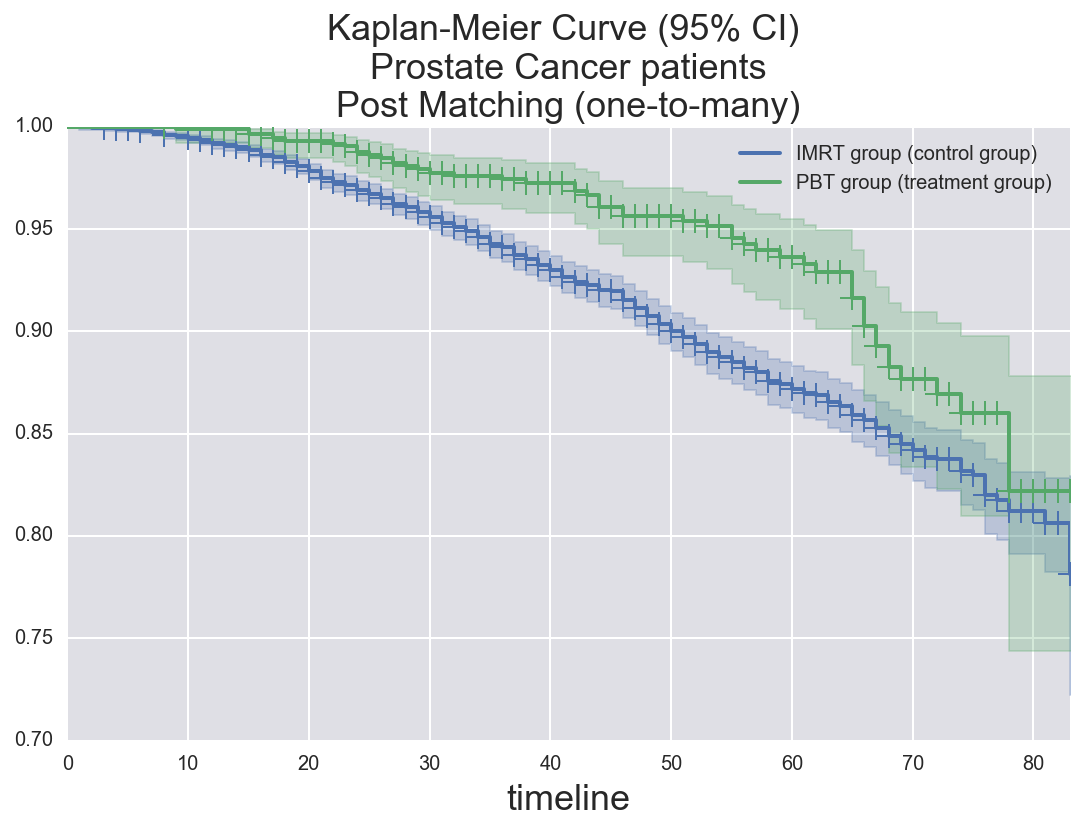

In [166]:
ax = kmfcontrol.plot(show_censors=True)
kmftreatment.plot(ax=ax, show_censors=True)
#kmfpop.plot(ax=ax, show_censors=True)
plt.title("Kaplan-Meier Curve (95% CI) \nProstate Cancer patients\nPost Matching (one-to-many)");
plt.savefig('prostatekm_postmatching.pdf')

In [150]:
from lifelines.statistics import logrank_test
results = logrank_test(Ttreatment, Tcontrol, Etreatment, Econtrol)
results.print_summary()

Results
   alpha: 0.95
   null distribution: chi squared
   test: logrank
   t 0: -1
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00034 |             12.831 |      Reject Null    |        True       


In [168]:
goodcols = ['m_sex','marst1', 'srace','nhiade',
           'grade1','site1','chemo',
           'lat1','histrec1','dajccstg1',
           'modx1','birthyr',
           'agedx1','countystate_1',
           'yrdx1','elevation_1',
           'lng_1','lat_1','League']

In [169]:
dfpop['League'] = y

In [170]:
cc = dd.copy()
id(cc) == id(dd)

False

In [171]:
#df = df.set_index('patient_id',drop=False)

In [172]:
dfpop.head()

,casereg,patient_id,casenumber,fivepct,medicaredateofdeath,birthm,birthyr,m_sex,race,state,...,icdot09_4_description,icdot09_5_description,icdot09_6_description,icdot09_7_description,icdot09_8_description,icdot09_9_description,icdot09_10_description,class,chemo,League
patient_id,,,,,,,,,,,,,,,,,,,,,
0232466001,Connecticut (1973+),0232466001,32466001,Not included,NaN,Dec,1937,Female,White,09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMRT,1,0
0237405040,Connecticut (1973+),0237405040,37405040,Not included,NaN,Jun,1924,Male,White,09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMRT,1,0
0239435040,Connecticut (1973+),0239435040,39435040,Not included,4272011.0,Feb,1944,Male,White,09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMRT,1,0
0242412040,Connecticut (1973+),0242412040,42412040,Not included,10212009.0,Aug,1950,Male,White,09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMRT,1,0
0243456001,Connecticut (1973+),0243456001,43456001,Not included,NaN,Jan,1929,Female,White,09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMRT,1,0


In [173]:
dfpop[goodcols].loc[cc[list(cc.keys())[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
2550040005,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1933,72,"Pierce County, WA",2006,813.384896,-122.129527,47.067588,0
2557079015,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1930,75,"Pierce County, WA",2006,813.384896,-122.129527,47.067588,0
2549063095,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1936,69,"Pierce County, WA",2006,813.384896,-122.129527,47.067588,0
2582053055,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1932,74,"Snohomish County, WA",2007,737.170045,-121.833947,48.032998,0
2575016085,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1930,75,"Thurston County, WA",2006,344.473657,-122.769599,46.864575,0
2582026035,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1935,71,"King County, WA",2007,1164.224817,-121.983603,47.548034,0
2550022015,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1929,76,"Pierce County, WA",2006,813.384896,-122.129527,47.067588,0
2578049035,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1931,75,"Pierce County, WA",2007,813.384896,-122.129527,47.067588,0
2586010025,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1930,76,"King County, WA",2007,1164.224817,-121.983603,47.548034,0


In [174]:
dfpop[goodcols].loc[[list(cc.keys())[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
2582072045,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1933,72,"Snohomish County, WA",2006,737.170045,-121.833947,48.032998,1


In [175]:
list(set([list(cc.keys())[0]]).union(set(cc[list(cc.keys())[0]])))

['2582072045',
 '2582053055',
 '2586010025',
 '2550040005',
 '2557079015',
 '2549063095',
 '2582026035',
 '2575016085',
 '2578049035',
 '2550022015',
 '2506043046']

In [176]:
dfpop[goodcols].loc[list(set([list(cc.keys())[0]]).union(set(cc[list(cc.keys())[0]])))]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
2582072045,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1933,72,"Snohomish County, WA",2006,737.170045,-121.833947,48.032998,1
2582053055,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1932,74,"Snohomish County, WA",2007,737.170045,-121.833947,48.032998,0
2586010025,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1930,76,"King County, WA",2007,1164.224817,-121.983603,47.548034,0
2550040005,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1933,72,"Pierce County, WA",2006,813.384896,-122.129527,47.067588,0
2557079015,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1930,75,"Pierce County, WA",2006,813.384896,-122.129527,47.067588,0
2549063095,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1936,69,"Pierce County, WA",2006,813.384896,-122.129527,47.067588,0
2582026035,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1935,71,"King County, WA",2007,1164.224817,-121.983603,47.548034,0
2575016085,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1930,75,"Thurston County, WA",2006,344.473657,-122.769599,46.864575,0
2578049035,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Feb,1931,75,"Pierce County, WA",2007,813.384896,-122.129527,47.067588,0


In [177]:
dfpop[goodcols].loc[list(set([list(cc.keys())[1]]).union(set(cc[list(cc.keys())[1]])))]


,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
8849029401,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1939,71,"Nevada County, CA",2010,1527.936188,-121.171039,39.134667,0
8888043431,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1944,66,"San Bernardino County, CA",2010,2586.306757,-116.419389,34.959208,1
8872034314,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1942,66,"San Bernardino County, CA",2008,2586.306757,-116.419389,34.959208,0
8827047480,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1944,65,"Fresno County, CA",2009,3403.719313,-119.232078,36.985898,0
8823085420,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1940,68,"Contra Costa County, CA",2008,1419.385520,-121.901795,37.853409,0
8856039374,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1942,66,"Contra Costa County, CA",2008,1419.385520,-121.901795,37.853409,0
8803067384,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1939,69,"Kern County, CA",2008,1179.140084,-118.859680,35.493727,0


In [178]:
dfpop[goodcols].loc[list(set([list(cc.keys())[2]]).union(set(cc[list(cc.keys())[2]])))]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
8871062400,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1938,71,"Kern County, CA",2009,1179.140084,-118.859680,35.493727,0
8813089410,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1936,73,"Orange County, CA",2009,76.362632,-117.831143,33.717471,1
8865088470,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1931,78,"Los Angeles County, CA",2009,284.596325,-118.243660,34.052227,0
8885036392,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1933,72,"Imperial County, CA",2006,-141.646210,-115.473355,33.011369,0
8851024402,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1936,74,"Santa Clara County, CA",2010,91.647673,-121.890704,37.333658,0
8808012331,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1929,77,"Tulare County, CA",2006,929.536624,-118.859680,36.134174,0
8889001302,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1929,78,"Madera County, CA",2007,2684.190090,-119.696268,37.251926,0
8837009412,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1932,78,"Los Angeles County, CA",2010,284.596325,-118.243660,34.052227,0
8850067460,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1941,68,"San Diego County, CA",2009,49.912809,-117.161097,32.715730,0


# <font color="#E56717">So we have 869 unique pure PBT treatment patients matched very closely with 4505 unique pure IMRT patients</font>

# <font color="#E56717">Now here is the Kaplna-Meier plot of the post-matching treatment and control groups</font>

In [162]:
import pickle
fileObject = open('many_to_one_dict.pickle','wb')
pickle.dump(dd,fileObject)
fileObject.close()

In [179]:
dfpop[goodcols].loc[list(set([list(cc.keys())[2]]).union(set(cc[list(cc.keys())[2]])))]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
8871062400,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1938,71,"Kern County, CA",2009,1179.140084,-118.859680,35.493727,0
8813089410,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1936,73,"Orange County, CA",2009,76.362632,-117.831143,33.717471,1
8865088470,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1931,78,"Los Angeles County, CA",2009,284.596325,-118.243660,34.052227,0
8885036392,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1933,72,"Imperial County, CA",2006,-141.646210,-115.473355,33.011369,0
8851024402,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1936,74,"Santa Clara County, CA",2010,91.647673,-121.890704,37.333658,0
8808012331,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1929,77,"Tulare County, CA",2006,929.536624,-118.859680,36.134174,0
8889001302,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1929,78,"Madera County, CA",2007,2684.190090,-119.696268,37.251926,0
8837009412,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1932,78,"Los Angeles County, CA",2010,284.596325,-118.243660,34.052227,0
8850067460,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1941,68,"San Diego County, CA",2009,49.912809,-117.161097,32.715730,0


In [180]:
dfpop[goodcols].loc[list(set([list(cc.keys())[2]]).union(set(cc[list(cc.keys())[2]])))]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
8871062400,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1938,71,"Kern County, CA",2009,1179.140084,-118.859680,35.493727,0
8813089410,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1936,73,"Orange County, CA",2009,76.362632,-117.831143,33.717471,1
8865088470,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1931,78,"Los Angeles County, CA",2009,284.596325,-118.243660,34.052227,0
8885036392,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1933,72,"Imperial County, CA",2006,-141.646210,-115.473355,33.011369,0
8851024402,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1936,74,"Santa Clara County, CA",2010,91.647673,-121.890704,37.333658,0
8808012331,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1929,77,"Tulare County, CA",2006,929.536624,-118.859680,36.134174,0
8889001302,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1929,78,"Madera County, CA",2007,2684.190090,-119.696268,37.251926,0
8837009412,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1932,78,"Los Angeles County, CA",2010,284.596325,-118.243660,34.052227,0
8850067460,Male,Married (including common law),White,"Spanish/Hispanic/Latino, NOS",Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Nov,1941,68,"San Diego County, CA",2009,49.912809,-117.161097,32.715730,0


In [181]:
dfpop[goodcols].loc[list(set([list(cc.keys())[798]]).union(set(cc[list(cc.keys())[798]])))]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
4362230090,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Dec,1941,69,"Sabine Parish, LA",2010,342.445760,-93.500345,31.489325,0
8835074384,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Dec,1937,71,"Riverside County, CA",2008,827.483657,-117.396119,33.953297,0
8842021450,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Dec,1935,74,"Santa Clara County, CA",2009,91.647673,-121.890704,37.333658,0
8810069420,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Dec,1936,73,"San Mateo County, CA",2009,616.829909,-122.401419,37.433734,0
8845068452,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Dec,1937,71,"San Diego County, CA",2008,49.912809,-117.161097,32.715730,0
8854086344,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Dec,1937,71,"Riverside County, CA",2008,827.483657,-117.396119,33.953297,0
8844088460,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Dec,1936,73,"Sacramento County, CA",2009,55.399456,-121.354163,38.474670,0
4365259040,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Dec,1940,69,"Bossier Parish, LA",2009,247.575162,-93.662324,32.755132,0
8819069324,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,1,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Dec,1937,71,"Santa Barbara County, CA",2008,41.889482,-119.698206,34.420832,0


In [182]:
dfpop[goodcols].loc[list(set([list(cc.keys())[98]]).union(set(cc[list(cc.keys())[98]])))]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
8833053323,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...","Lung, NOS",1,Left: origin of primary,8140-8398: adenomas and adenocarcinomas,Stage IV,Sep,1935,72,"Riverside County, CA",2007,827.483657,-117.396119,33.953297,1
4422160014,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...","Lung, NOS",1,Left: origin of primary,8140-8398: adenomas and adenocarcinomas,Stage IV,Sep,1935,73,"Ocean County, NJ",2008,58.865580,-74.311821,39.965255,0


In [183]:
dfpop[goodcols].loc[list(set([list(cc.keys())[198]]).union(set(cc[list(cc.keys())[198]])))]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
8833003335,Male,Divorced,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Jun,1940,68,"Contra Costa County, CA",2009,1419.385520,-121.901795,37.853409,0
8787088540,Male,Divorced,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Jun,1946,65,"Coweta County, GA",2011,877.411037,-84.731556,33.371671,0
8860037355,Male,Divorced,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Jun,1944,65,"Monterey County, CA",2009,1892.575903,-121.354163,36.313620,1
4253025064,Male,Divorced,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Jun,1943,65,"Campbell County, KY",2009,681.095696,-84.396254,38.895189,0
8809012345,Male,Divorced,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Jun,1941,67,"Tehama County, CA",2009,251.833481,-122.174605,40.098220,0
4251085074,Male,Divorced,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Jun,1941,68,"Wayne County, KY",2010,953.554700,-84.856793,36.757191,0
8856075374,Male,Divorced,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Jun,1937,70,"Los Angeles County, CA",2008,284.596325,-118.243660,34.052227,0
4288097084,Male,Divorced,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Jun,1942,69,"Pulaski County, KY",2011,866.227466,-84.522219,37.085351,0
2238149080,Male,Divorced,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Jun,1949,60,"Scott County, IA",2009,734.612746,-90.639370,41.639320,0


In [184]:
dfpop[goodcols].loc[list(set([list(cc.keys())[99]]).union(set(cc[list(cc.keys())[99]])))]

,m_sex,marst1,srace,nhiade,grade1,site1,chemo,lat1,histrec1,dajccstg1,modx1,birthyr,agedx1,countystate_1,yrdx1,elevation_1,lng_1,lat_1,League
patient_id,,,,,,,,,,,,,,,,,,,
8810019371,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1933,73,"San Diego County, CA",2006,49.912809,-117.161097,32.715730,0
8852027332,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1931,76,"Riverside County, CA",2007,827.483657,-117.396119,33.953297,1
8895099360,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1929,77,"Orange County, CA",2006,76.362632,-117.831143,33.717471,0
8858004063,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1930,77,"Ventura County, CA",2008,1206.394545,-119.139064,34.370488,0
8846076321,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1935,71,"Los Angeles County, CA",2006,284.596325,-118.243660,34.052227,0
8838063372,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1935,72,"Alameda County, CA",2007,713.249840,-121.719546,37.601689,0
8864000321,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1933,72,"Orange County, CA",2006,76.362632,-117.831143,33.717471,0
8812076354,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1932,76,"Los Angeles County, CA",2008,284.596325,-118.243660,34.052227,0
8877092372,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,0,Not a paired site,8140-8398: adenomas and adenocarcinomas,Stage II,Oct,1933,73,"Marin County, CA",2007,857.813605,-122.763304,38.083403,0
